In [1]:
#dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, BertModel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(torch.__version__)

c:\Users\User\Desktop\El final\AIML\my repo\Assignments\assignment_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.5.1+cu121


In [ ]:
#dataset is not too big, 120 000 rows, just text, doesnt need to be streamed...
dataset = load_dataset("fancyzhx/ag_news")

In [ ]:
#data is exlusively text based, so lets tokenize
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(entry): #function to take in text, tokenize it and return tokenized text (entry)
    tokens= tokenizer(
        entry["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=128,
        return_tensors="pt"
    )
    return {"input_ids": tokens.input_ids.squeeze(0), "attention_mask": tokens.attention_mask.squeeze(0), "label": entry["label"]}

In [5]:
#run preprocessing of data. 
processed_data = [preprocess_data(entry) for entry in dataset['train']]

In [ ]:
class NewsDataset(Dataset): #class to hold dataset, not 100% needed but nth
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
dataloader = DataLoader(NewsDataset(processed_data), batch_size=32, shuffle=True)

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, num_classes=4): #init with 4 since 4 possible outputs from model. 
        super(TextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased") #use bert
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)


In [ ]:
# Model setup
model = TextClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)
model.to(device)

print(torch.__version__) #checking if torch version really supporting CUDA


True
cuda
2.5.1+cu121


In [ ]:
def train_model(model, dataloader, criterion, optimizer, epochs=3): #3 epochs, took about 33.5 minutes to train fully on local machine. 
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),  # Move to GPU
                batch["attention_mask"].to(device),
                batch["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

#Train the model
train_model(model, dataloader, criterion, optimizer)

Epoch [1/3], Loss: 0.2553
Epoch [2/3], Loss: 0.1763
Epoch [3/3], Loss: 0.1718


              precision    recall  f1-score   support

           0       0.99      0.95      0.97     30000
           1       0.99      0.99      0.99     30000
           2       0.97      0.95      0.96     30000
           3       0.93      0.98      0.96     30000

    accuracy                           0.97    120000
   macro avg       0.97      0.97      0.97    120000
weighted avg       0.97      0.97      0.97    120000



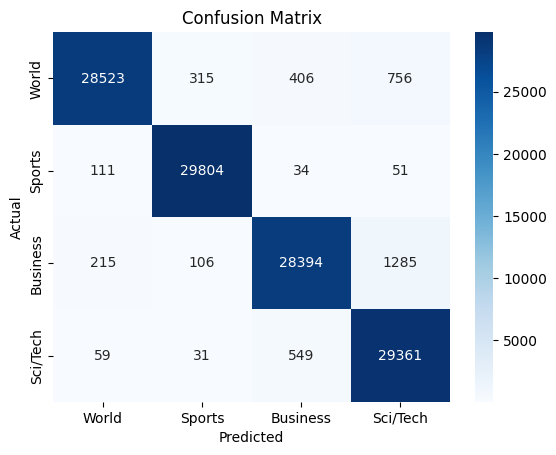

In [ ]:
#Evaluate model
model.eval()
all_preds, all_labels = [], []
for batch in dataloader:
    input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

#Confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["World", "Sports", "Business", "Sci/Tech"], yticklabels=["World", "Sports", "Business", "Sci/Tech"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#for fun testing

label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

def predict_text(text, model, tokenizer, device):
    model.eval()
    
    
    tokens = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )


    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)


    with torch.no_grad():
        output = model(input_ids, attention_mask)
        prediction = torch.argmax(output, dim=1).cpu().item()


    return label_map[prediction]


#Example texts
test_samples = [
    "The president met with world leaders to discuss global trade policies.",
    "The Lakers won the NBA championship after a thrilling game.",
    "Stock markets have surged as investors gain confidence in the economy.",
    "NASA has discovered a new exoplanet that could be habitable."
]

for text in test_samples:
    prediction = predict_text(text, model, tokenizer, device)
    print(f"Text: {text}\nPredicted Category: {prediction}\n")






Text: The president met with world leaders to discuss global trade policies.
Predicted Category: World

Text: The Lakers won the NBA championship after a thrilling game.
Predicted Category: Sports

Text: Stock markets have surged as investors gain confidence in the economy.
Predicted Category: Business

Text: NASA has discovered a new exoplanet that could be habitable.
Predicted Category: Sci/Tech

